# Value-at-Risk (VaR): Application of GARCH Models

The following analysis is based on content from Loriano Mancini's lecture on ARCH/GARCH models at USI Lugano and the Swiss Finance Institute.  

Value-at-Risk (VaR) measures potential portfolio losses and is a key risk metric enforced by regulators like the Basel Committee (1996). Since financial returns show volatility clustering, GARCH models are commonly used to estimate time-varying risk, improving VaR accuracy. Below, we show an implementation of GARCH-based VaR estimation using S&P 500 data.

### Brief Guide to the Notebook

Data is downloaded directly from Yahoo Finance, so no CSV files are required. The theory behind VaR and ES is briefly introduced before applying GARCH models to real data. Users can modify parameters, such as $z_{0.01}$ values or time periods, if desired. The notebook should be run sequentially; using "Run All" is recommended for consistency.

### Libraries

In [1]:
# Uncomment the following lines to install the required libraries if they are not already installed
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install yfinance
#!pip install scipy
#!pip install statsmodels
#!pip install arch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
from scipy.stats import norm
from arch import arch_model

### Value-at-Risk Introduction

Simply put, VaR represents the left-tail quantile of the profit and loss (P&L) distribution over a given time horizon. 

At time $t$, for a 1% VaR, we determine the threshold where:  

$$
P(r_{t+1} < -VaR_{t,t+1} | \mathcal{F}_t) = 0.01
$$

For example, if $VaR_{t,t+1} = -0.05$, then:

$$
P(r_{t+1} < -0.05 | \mathcal{F}_t) = 0.01
$$

Log returns are defined as:

$$
r_{t+1} = \log \left( \frac{S_{t+1}}{S_t} \right)
$$

Where:
- $r_{t+1}$: Return from time $t$ to $t+1$  
- $S_t$: Stock price at time $t$  
- $S_{t+1}$: Stock price at time $t+1$  
- $\mathcal{F}_t$: Information set available at time $t$, including all past and present data relevant for forecasting future returns  

The plot below illustrates the 1% VaR threshold as the left-tail quantile of a normal profit and loss distribution.

**Note:** Here, we assume a normal distribution for illustration. However, financial returns typically exhibit leptokurtosis, meaning they have heavier tails than the normal distribution. 

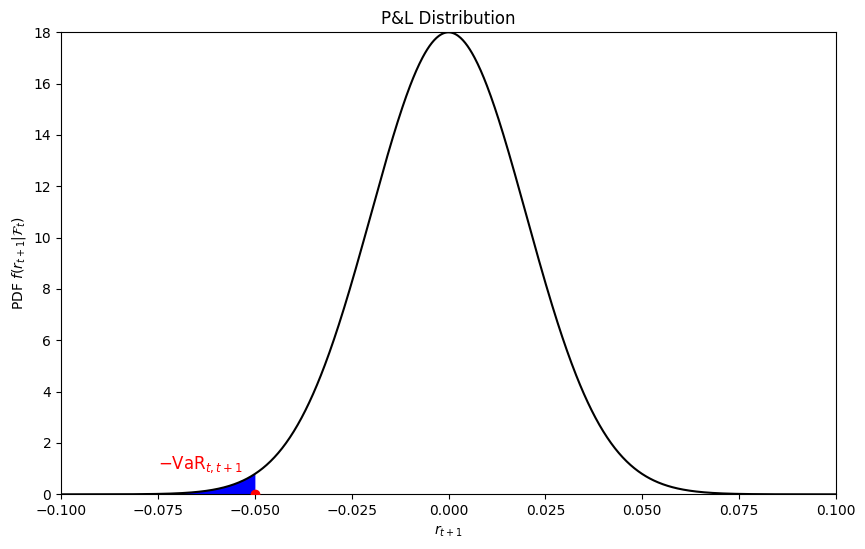

In [3]:
# Define parameters for the normal distribution (assumed for illustration)
mu = 0  # Mean
sigma = 0.02  # Standard deviation 

# Generate x values for normal distribution
x = np.linspace(-0.1, 0.1, 1000)  
pdf = norm.pdf(x, mu, sigma)

# Scale the PDF 
pdf = pdf * (18 / max(pdf))

# Define 1% VaR threshold
VaR_1pct = -0.05  

# Plot the normal distribution 
plt.figure(figsize=(10,6))
plt.plot(x, pdf, color="black")

# Fill the left-tail region for VaR
plt.fill_between(x, pdf, where=(x <= VaR_1pct), color="blue")

# Pinpoint the exact VaR level with a red marker on the x-axis
plt.scatter([VaR_1pct], [0], color="red", zorder=3)
plt.text(VaR_1pct - 0.025, 1, r"$-\mathrm{VaR}_{t,t+1}$", fontsize=12, color="red")

# Labels 
plt.title("P&L Distribution")
plt.xlabel(r"$r_{t+1}$")
plt.ylabel(r"PDF $f(r_{t+1} | \mathcal{F}_t)$") 

plt.ylim(0, 18)
plt.xlim(-0.1, 0.1)

plt.show()

### Computing VaR 

As a reminder, a GARCH model is defined as:

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2, \quad r_t = \sigma_t z_t
$$

Where:
- $z_t$: Shocks, typically assumed to follow a standard normal distribution $N(0,1)$ and i.i.d.  
- $\sigma_t$: Conditional volatility, representing time-varying risk estimated from historical data  

At time $t$, since $\sigma_{t+1} \in \mathcal{F}_t$, the only random variable is $z_{t+1}$. Thus, we can express the probability of a 1% VaR exceedance as:  

$$
0.01 = P(r_{t+1} < -VaR_{t,t+1} | \mathcal{F}_t)
$$

In a GARCH model, we can substitute $r_{t+1} = \sigma_{t+1} z_{t+1}$:

$$
P(\sigma_{t+1} z_{t+1} < -VaR_{t,t+1} | \mathcal{F}_t)
$$

Rearranging:

$$
P(z_{t+1} < -VaR_{t,t+1} / \sigma_{t+1} | \mathcal{F}_t)
$$

Since $z_{t+1}$ follows a known distribution, we define the VaR threshold:

$$
-\frac{VaR_{t,t+1}}{\sigma_{t+1}} = z_{0.01}
$$

where $z_{0.01}$ is the 1% quantile of the distribution of $z$.  

For example, if $z \sim N(0,1)$, then:

$$
z_{0.01} = -2.3
$$

Thus, the 1% level VaR over the horizon $[t, t+1]$ is:

$$
VaR_{t,t+1} = -\sigma_{t+1} z_{0.01}
$$

These calculations apply to any $\sigma_{t+1} \in \mathcal{F}_t$, not just GARCH models.

### Backtesting VaR

The figure below presents daily S&P 500 log-returns along with the 1% VaR threshold estimated using a standard GARCH(1,1) model. The VaR level is calculated as:  

$$
- VaR_{t,t+1} = \sigma_{t+1} z_{0.01}
$$

With $z_{0.01}$ obtained from the empirical distribution of $z$, calculated as the 1% quantile of the estimated innovations:  

$$
z_{0.01} = \text{quantile}(\hat{z}_{t+1}, 1\%) \approx -2.6
$$  

With estimated innovations being defined as:

$$
\hat{z}_{t+1} = \frac{r_{t+1}}{\sigma_{t+1}}
$$

Here $\hat{z}_{t+1}$ estimates the i.i.d. shocks driving returns from $t$ to $t+1$, based on the volatility dynamics of the GARCH model.

Key results:
- Observed violations: 109 days  
- Total days analyzed: 10,338  

The empirical violation rate is defined as: 

$$
\frac{109}{10,338} \times 100 = 1.05\%
$$

The expected violation rate, by definition, is 1%, and our results are very close to this theoretical expectation, confirming the validity of the model.

If instead we assume a normal distribution and use $z_{0.01} = -2.3$, the VaR threshold would be higher (less negative), leading to more violations since more returns would fall below the estimated risk limit. This would result in an underestimation of risk, as the model would fail to account for fat tails in real financial data.

Also, for simplicity, the default model in `arch` is used, which assumes normally distributed innovations.

**Note**: Returns are scaled by 100 for better convergence (otherwise, Python would typically raise a warning). This scaling also allows log returns to be interpreted as percentage changes, which can be justified using a Taylor expansion. However, this approximation is only valid for small changes. Naturally, VaR scales accordingly.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Empirical z_0.01 (1% quantile of estimated innovations): -2.6381
Total VaR violations: 109 out of 10338 days (1.05%)


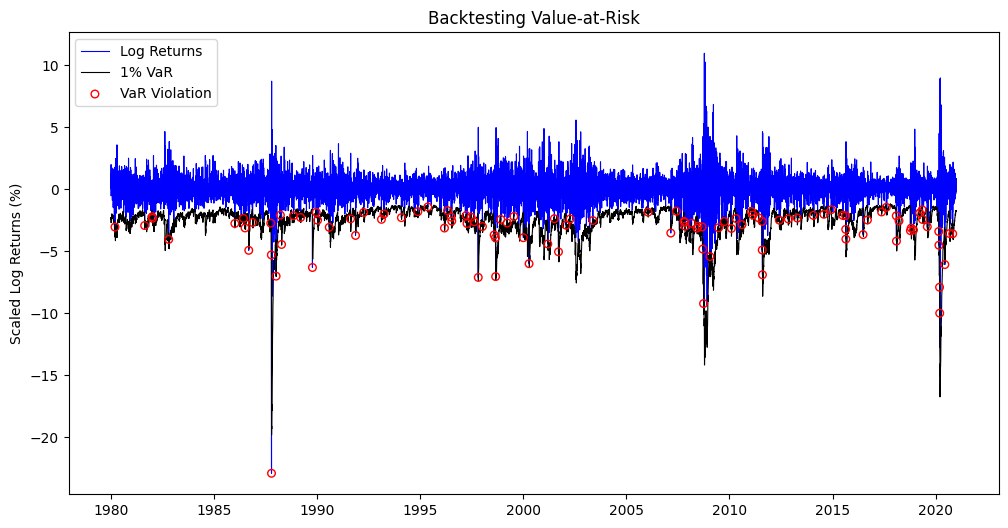

In [4]:
# Download S&P 500 data
sp500_data = yf.download("^GSPC", start="1980-01-01", end="2020-12-31", multi_level_index=False)

# Compute log returns and scale them by 100 for better convergence
sp500_data["Log Returns"] = 100 * np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))
sp500_data.dropna(inplace=True)

# Fit a GARCH(1,1) model
garch_model = arch_model(sp500_data["Log Returns"], vol="Garch", p=1, q=1) 
garch_fit = garch_model.fit(disp="off")

# Get conditional volatility estimates
sp500_data["Volatility"] = garch_fit.conditional_volatility # Convenient property of the arch package, returns the full time series conditional volatility

# Compute estimated innovations
sp500_data["Estimated Innovations"] = sp500_data["Log Returns"] / sp500_data["Volatility"]

# Calculate the empirical 1% quantile of the innovations
z_0_01_empirical = np.percentile(sp500_data["Estimated Innovations"], 1)

# Print the result
print(f"Empirical z_0.01 (1% quantile of estimated innovations): {z_0_01_empirical:.4f}")

# Compute 1% VaR using empirical quantile (z_0.01 = -2.6)
z_0_01 = -2.6  # Can be modified to experiment with different values
sp500_data["VaR_1%"] = -sp500_data["Volatility"] * z_0_01

# Identify VaR violations (returns below -VaR)
sp500_data["VaR Violation"] = sp500_data["Log Returns"] < -sp500_data["VaR_1%"]

# Count total violations
total_violations = sp500_data["VaR Violation"].sum()
total_days = len(sp500_data)
violation_rate = (total_violations / total_days) * 100  

print(f"Total VaR violations: {total_violations} out of {total_days} days ({violation_rate:.2f}%)")

# Plot the results
plt.figure(figsize=(12,6))

# Plot log returns 
plt.plot(sp500_data.index, sp500_data["Log Returns"], color='blue', linewidth=0.8, label="Log Returns")

# Plot 1% VaR level 
plt.plot(sp500_data.index, -sp500_data["VaR_1%"], color='black', linewidth=0.8, label="1% VaR")

# Highlight violations with empty red circles
plt.scatter(
    sp500_data.index[sp500_data["VaR Violation"]],
    sp500_data["Log Returns"][sp500_data["VaR Violation"]],
    edgecolors='red', facecolors='none', s=30, label="VaR Violation", zorder=3
)

# Labels & legend
plt.title("Backtesting Value-at-Risk")
plt.ylabel("Scaled Log Returns (%)") 
plt.legend()

plt.show()

**Note on Yahoo Finance Update (Feb 2025)**  
- New Multi-Index Column Structure: Data now has a two-level column format.  
- Price Adjustments: "Close" is now fully adjusted for splits and dividends.  
- Key Change: Previously, we needed "Adj Close" for total return calculations, now "Close" suffices.  

If you prefer the old data structure, set `multi_level_index=False` when downloading data. If you want non-adjusted prices, set `auto_adjust=False` to retrieve raw closing prices.

### Backtesting VaR: Nov 2019 – Nov 2020

The figure below shows daily S&P 500 log-returns, the 1% VaR threshold and violations over a more focused period. 

Between Nov 2019 and Nov 2020, there were 7 violations out of 272 days, resulting in an observed violation rate of 2.57%, which is relatively close to the expected 1% level.

Total VaR violations: 7 out of 272 days (2.57%)


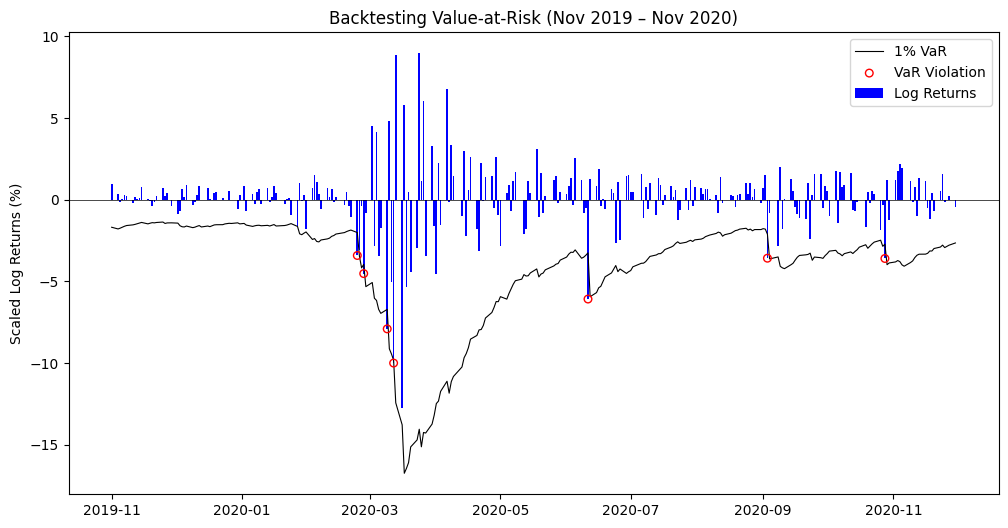

In [5]:
# Filter the existing data for the required period
sp500_subset = sp500_data.loc["2019-11-01":"2020-11-30"].copy()

# Count total violations in the subset
total_violations_subset = sp500_subset["VaR Violation"].sum()
total_days = len(sp500_subset)
violation_rate_subset = (total_violations_subset / total_days) * 100  

print(f"Total VaR violations: {total_violations_subset} out of {total_days} days ({violation_rate_subset:.2f}%)")

# Plot the results
plt.figure(figsize=(12,6))

# Plot log returns 
plt.bar(sp500_subset.index, sp500_subset["Log Returns"], color='blue', label="Log Returns")

# Plot 1% VaR level 
plt.plot(sp500_subset.index, -sp500_subset["VaR_1%"], color='black', linewidth=0.8, label="1% VaR")

# Add a thin black line at zero
plt.axhline(0, color='black', linewidth=0.5)

# Highlight violations with red circles
plt.scatter(
    sp500_subset.index[sp500_subset["VaR Violation"]],
    sp500_subset["Log Returns"][sp500_subset["VaR Violation"]],
    edgecolors='red', facecolors='none', s=30, label="VaR Violation", zorder=3
)

# Labels & legend
plt.title("Backtesting Value-at-Risk (Nov 2019 – Nov 2020)")
plt.ylabel("Scaled Log Returns (%)")
plt.legend()

plt.show()

### Expected Shotfall (ES) 

Note how VaR only measures a threshold beyond which losses occur but does not quantify the magnitude of those extreme losses. To address this, regulators require additional risk measures, such as Expected Shortfall, also known as Conditional VaR.

If returns exceed the VaR threshold, the expected loss is given by:

$$
-ES_{t,t+1} = E[r_{t+1} | r_{t+1} < -VaR_{t,t+1}, \mathcal{F}_t]
$$

Substituting $r_{t+1} = \sigma_{t+1} z_{t+1}$:

$$
E[r_{t+1} | r_{t+1} < -VaR_{t,t+1}, \mathcal{F}_t] = E[\sigma_{t+1} z_{t+1} | \sigma_{t+1} z_{t+1} < \sigma_{t+1} z_{0.01}]
$$

Factoring out $\sigma_{t+1}$:

$$
-ES_{t,t+1} = \sigma_{t+1} E[z_{t+1} | z_{t+1} < z_{0.01}]
$$

where $E[z_{t+1} | z_{t+1} < z_{0.01}]$ is the ES at the 1% level of the shocks $z$, which can be estimated in a series of different ways.

Again, this definition holds for any $\sigma_{t+1} \in \mathcal{F}_t$, not just for GARCH models.


### ES: Nov 2019 - Nov 2020

Returning to the November period, we update the analysis by computing ES.  

This is done by:
- Estimating $E[\hat{z}_{t+1} | \hat{z}_{t+1} < z_{0.01}]$ as the mean of calculated innovations below $z_{0.01} = -2.6$
- Multiplying by $\sigma_{t+1}$ to obtain ES for each day  

The figure below now includes ES to show the expected loss in extreme cases.

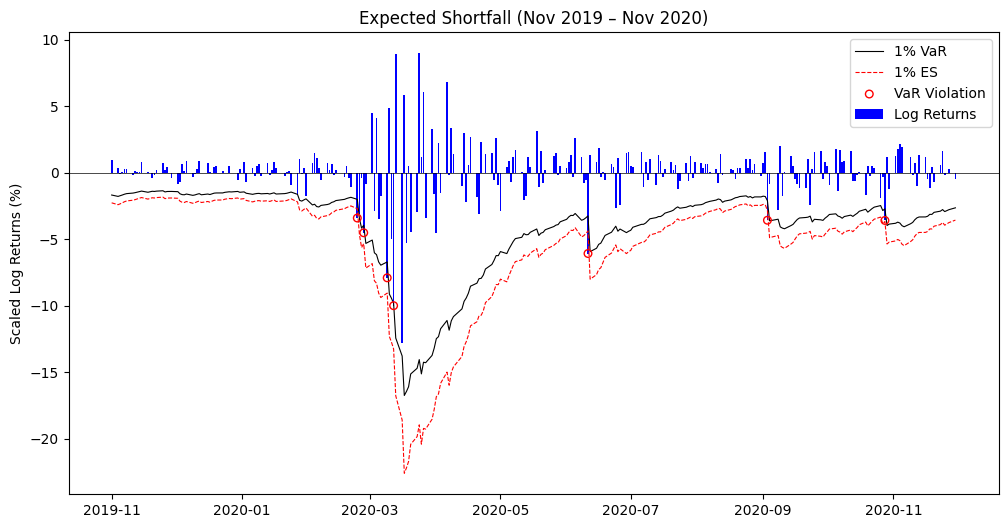

In [6]:
# Compute empirical ES component: mean of estimated innovations below z_0.01
z_0_01_ES = sp500_data["Estimated Innovations"][sp500_data["Estimated Innovations"] < z_0_01].mean()

# Compute ES using the GARCH volatility
sp500_data["ES_1%"] = -sp500_data["Volatility"] * z_0_01_ES

# Filter ES values for the subset time range
sp500_subset["ES_1%"] = sp500_data.loc[sp500_subset.index, "ES_1%"]

# Recreate the figure with ES included
plt.figure(figsize=(12,6))

# Plot log returns 
plt.bar(sp500_subset.index, sp500_subset["Log Returns"], color='blue', label="Log Returns")

# Plot 1% VaR level
plt.plot(sp500_subset.index, -sp500_subset["VaR_1%"], color='black', linewidth=0.8, label="1% VaR")

# Plot Expected Shortfall 
plt.plot(sp500_subset.index, -sp500_subset["ES_1%"], color='red', linestyle="dashed", linewidth=0.8, label="1% ES")

# Add a thin black line at zero
plt.axhline(0, color='black', linewidth=0.5)

# Highlight violations with red circles
plt.scatter(
    sp500_subset.index[sp500_subset["VaR Violation"]],
    sp500_subset["Log Returns"][sp500_subset["VaR Violation"]],
    edgecolors='red', facecolors='none', s=30, label="VaR Violation", zorder=3
)

# Labels & legend 
plt.title("Expected Shortfall (Nov 2019 – Nov 2020)")
plt.ylabel("Scaled Log Returns (%)")
plt.legend()

plt.show()

### References
- Mancini, Loriano. *Asset Returns: Stylized Facts and ARCH/GARCH Models.* USI Lugano and Swiss Finance Institute, Financial Econometrics Course.  
- Barigozzi, Matteo. *GARCH Models.* London School of Economics, UK. CIDE–Bertinoro Course for PhD Students, 2014.  